In [1]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import date
import tensorflow as tf
from datetime import date
import time

2024-08-05 16:37:43.029343: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Compute current value function using the value function from the next time period
def CalcValueNoUnc(d, c, P, eta, vi, ed, iC, iD):
    """
    Title: Calculate Risk-Neutral value function using deterministic price
    Inputs:
        d - price right now
        c - marginal discharge cost
        P - power rating w.r.t to energy rating and sampling time,
        i.e., 2hr duration battery with 5min resolution -> P = (1/2)/12 
        eta - efficiency
        vi - input value function for the next time period, which equals to
        v_t(e) where e is sampled from 0 to 1 at the granularity e
        ed - granularity at which vi is sampled, in p.u. to energy rating
    Outputs:
        vo - value function for the current time period sampled at ed
    """
    # add a large number of upper and lower v, where the first point is
    # v_t(0-) = +infty, and the second point is v_t(0), the second largest one is
    # v_t(1), and the largest one is v_t(1+) = -infty
    lNum = 1e5*np.ones((1,))
    v_foo = np.concatenate([lNum, vi, -lNum], axis=0)

    # # calculate soc after charge vC = v_t(e+P*eta)
    vC = v_foo[iC]

    # # calculate soc after discharge vC = v_t(e-P/eta)
    vD = v_foo[iD]

    # calculate CDF and PDF
    FtEC = (vi*eta > d).astype(int) # F_t(v_t(e)*eta)
    FtCC = (vC*eta > d).astype(int) # F_t(v_t(e+P*eta)*eta)
    FtED = ((vi/eta + c)*((vi/eta + c) > 0) > d).astype(int) # F_t(v_t(e)/eta + c) 
    FtDD = ((vD/eta + c)*((vD/eta + c) > 0) > d).astype(int) # F_t(v_t(e-P/eta)/eta + c) 

    # calculate terms
    Term1 = vC * FtCC
    Term2 = d*(vC*eta <= d)*(vi*eta > d)/ eta
    Term3 = vi * (FtED - FtEC)
    Term4 = d*(((vi/eta + c)*((vi/eta + c) > 0)) <= d)*(((vD/eta + c)*((vD/eta + c) > 0))>d) * eta
    Term5 = - c * eta * (FtDD - FtED)
    Term6 = vD * (1-FtDD)

    # output new value function samped at ed
    vo = Term1 + Term2 + Term3 + Term4 + Term5 + Term6
    return vo


def ArbValue(lmp, v, e, P, E, eta, c, N):
    """
        Title: Arbitrage test using value function

        lmp: lambda, electricity price over time period t
        v: marginal value function
        e: current SoC
        P: P = Pr * Ts; actual power rating taking time step size into account
        E: SoC upper limit, usually takes 1
        eta: eta = .9; # efficiency
        c: c = 10; # marginal discharge cost - degradation
        N: number of SOC samples, 1001
    """

    iE = np.ceil((N-1)*e/E).astype(int) # find the nearest SoC index. iE here is 1 smaller than MATLAB.

    vF = v.copy() # read the value function
    # charge efficiency: iE+1 to end in Matlab, so iE to end here
    vF[iE+1 :] = vF[iE+1 :] * eta
    # discharge efficiency: 1 to iE-1 in Matlab, so 0 to iE-1 (exclusive) here
    vF[0 : iE] = vF[0 : iE] / eta + c

    # charge index
    if len(np.nonzero(vF >= lmp)[0])>0:
        iC = np.max(np.nonzero(vF >= lmp))
    else:
        iC = None

    # discharge index
    if len(np.nonzero(vF <= lmp)[0])>0:
        iD = np.min(np.nonzero(vF <= lmp))
    else:
        iD = None

    # iF = iC*(iC > iE) + iD*(iD < iE) + iE*(iC <= iE)*(iD >= iE);
    if iC is not None:
        if iC > iE:
            iF = iC
        elif iD is not None:
            if iD < iE:
                iF = iD
            else:
                iF = iE
        else:
            iF = iE
    elif iD is not None:
        if iD < iE:
            iF = iD
        else:
            iF = iE
    else:
        iF = iE

    eF = (iF)/(N-1)*E
    eF = max(min(eF, e + P*eta), e-P/eta)
    pF = (e-eF)/eta*((e-eF) < 0) + (e-eF)*eta*((e-eF) > 0)
    
    return eF, pF

In [31]:
def generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, tlambda):
    '''
    Generate marginal value function v and dowmsampled marginal value function vAvg

    Ts: time step, 1/12
    P : P = Pr * Ts; # actual power rating taking time step size into account
    eta: eta = .9; # efficiency
    c: c = 10; # marginal discharge cost - degradation
    ed: ed = 0.001; # SoC sample granularity
    ef: ef = 0.5; # # final SoC target level
    Ne: Ne = math.floor(1/ed)+1  # number of SOC samples, (1/0.001)+1=1001
    T: Total time steps
    num_segment: dowmsample arginal value function v to num_segment vAvg
    tlambda: real-time price
    '''

    start_time = time.time()

    # Set final SoC level
    vEnd = np.zeros(Ne)
    vEnd[0:math.floor(ef * 1001)] = 1e2 # Use 100 as the penalty for final discharge level

    # Define the risk-neutral value function and populate the final column.
    # v[0, 0] is the marginal value of 0% SoC at the beginning of day 1, v[Ne, T]is the maringal value of 100% SoC at the beginning of the last operating day
    v = np.zeros((Ne, T+1)) # initialize the value function series
    v[:, -1] = vEnd  # v.shape == (1001, 210241)

    # Process indices: discretize vt by modeling it as an vector v_{t,j} in which each element is associated with equally spaced SoC samples
    es = np.arange(start=0, stop=1+ed, step=ed)

    # the number of samples is J = 1 + E/ed
    Ne = len(es)

    # Calculate soc after charge vC = v_t(e+P*eta)
    eC = es + P*eta  # [0.0375 0.0385 0.0395 ... 1.0355 1.0365 1.0375]
    iC = np.ceil(eC/ed)
    iC[iC > (Ne+1)] = Ne + 1
    iC[iC < 1] = 0
    # print(iC) # [  38.   39.   40. ... 1002. 1002. 1002.]
    # print(iC.shape) # (1001,)


    # Calculate soc after discharge vC = v_t(e-P/eta)
    eD = es - P/eta
    iD = np.floor(eD/ed)
    iD[iD > (Ne+1)] = Ne + 1
    iD[iD < 1] = 0
    # print(iD) # [  0.   0.   0. ... 951. 952. 953.]
    # print(iD.shape) # (1001,)


    # Populate marginal value function
    for t in reversed(range(0, T)): # start from the last day and move backwards
        vi = v[:, t+1] # input value function of next time stamp
        # added one day (24/Ts) to exclude first day, first day will be used as predictors only due to look-back window
        vo = CalcValueNoUnc(tlambda[int(t+24/Ts)], c, P, eta, vi, ed, iC.astype(int), iD.astype(int))
        v[:,t] = vo # record the result
    # print(v)
    # print(v.shape) # (1001, 210241)
    # print(np.sum(v)) # 6210425677.739915, MATLAB: 6.2082e+09

    end_time = time.time()
    print('Time:', end_time - start_time)

    # Downsample: https://stackoverflow.com/questions/14916545/numpy-rebinning-a-2d-array
    vAvg = v[0:1000, :].reshape([num_segment, int(1000/num_segment), v.shape[1], 1]).mean(3).mean(1)

    return v, vAvg

In [4]:
def generate_train(T, tlambda, num_RTP, vAvg):
    X_train = np.zeros((T, num_RTP))

    for t in range(T):
        X_train[t, :] = tlambda[t+289-num_RTP : t+289]

    y_train = vAvg.T[0:T, :]
    
    print(X_train.shape)
    print(y_train.shape)

    return X_train, y_train


In [5]:
# def generate_train(T, DAP, tlambda, start, stop, lastDay, num_DAP, num_RTP, vAvg):
#     X_train = np.zeros((T, num_DAP+num_RTP))

#     # if num_DAP > 0:
#     # DAP: previous (num_DAP-1) prices + current price
#     DAP_sub = DAP[::12] # Subsample DAP
#     lambda_DA_sub = DAP_sub[:, (len(DAP_sub[0])-lastDay+start-2):(len(DAP_sub[0])-lastDay+stop+1)]
#     tlambda_DA_sub = lambda_DA_sub.flatten('F')
#     for t in range(T):
#         X_train[t, 0:num_DAP] = tlambda_DA_sub[int(t/12)+37-num_DAP : int(t/12)+37]

#     # RTP: Previous (num_RTP-1) prices + current price
#     for t in range(T):
#         X_train[t, num_DAP:num_DAP+num_RTP] = tlambda[t+289-num_RTP : t+289]


#     y_train = vAvg.T[0:T, :]
    
#     print(X_train.shape)
#     print(y_train.shape)

#     return X_train, y_train

In [6]:
def train(X_train, y_train, input_size=60, dense_size=60, output_size=50, activation_fn='relu', epochs=10):
    model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_size,)),
        tf.keras.layers.Dense(dense_size, activation=activation_fn),
        tf.keras.layers.Dense(dense_size, activation=activation_fn),
        tf.keras.layers.Dense(output_size)
    ])
    print(model.summary())

    # Since we are doing regression, we use mean squared error here
    model.compile(optimizer='adam',
                loss=tf.keras.losses.MeanSquaredError())
    model.fit(X_train, y_train, epochs=epochs)
    return model

In [7]:
def evaluate_using_train():
    print("="*30)
    print('Evaluating using X_train')
    print("="*30)
    v2 = model.predict(X_train).T
    # print(v2.shape) # (20, 210240)
    '''
    Plot
    '''
    # plt.plot(v2[25,0:287], linestyle = 'dotted')
    # plt.plot(v[25,0:287], linestyle = 'dotted')
    # plt.show()

    '''
    Perform arbitrage
    '''
    eS = np.zeros(T) # generate the SoC series
    # print(eS.shape)

    pS = np.zeros(T) # generate the power series
    # print(pS.shape) # (210240,)

    e = e0 # initial SoC
    # print(e)

    for t in range(T-1): # start from the first day and move forwards
        vv = v2[:, t+1]
        e, p = ArbValue(RTP[288+t], vv, e, P, 1, eta, c, v2.shape[0])
        eS[t] = e # record SoC
        pS[t] = p # record Power

    ProfitOut = np.sum(pS * RTP[288:len(RTP)]) - np.sum(c * pS[pS>0])
    Revenue = np.sum(pS * RTP[288:len(RTP)])
    print('ProfitOut:', ProfitOut)
    print('Revenue:', Revenue)

    return(ProfitOut)

In [22]:
eS = np.zeros(T) # generate the SoC series
    # print(eS.shape)

pS = np.zeros(T) # generate the power series
    # print(pS.shape) # (210240,)

e = e0 # initial SoC
# print(e)

for t in range(T-1): # start from the first day and move forwards
    vv = v[:, t+1]
    e, p = ArbValue(RTP[288+t], vv, e, P, 1, eta, c, v.shape[0])
    eS[t] = e # record SoC
    pS[t] = p # record Power

ProfitOut = np.sum(pS * RTP[288:len(RTP)]) - np.sum(c * pS[pS>0])
Revenue = np.sum(pS * RTP[288:len(RTP)])
print('ProfitOut:', ProfitOut)
print('Revenue:', Revenue)

ProfitOut: 10485.22263150116
Revenue: 16560.006631501157


In [20]:
ProfitOut/1000*4

41.94089052600464

### Bidding Model Training with Multi Layor Perceptron 


In [23]:
### Read training real-time price
RTP = pd.read_csv('results/clearing_prices.csv', usecols = ['clearing_price']).values.reshape(-1)
load = pd.read_csv('data/CAISO_Load_2022.csv', usecols=['net_load']).values.flatten()

In [33]:
Ts = 1/12 # time step: 5min
T = len(RTP)-288

'''
Set parameters
'''
Pr = 0.5  # normalized power rating wrt energy rating (highest power input allowed to flow through particular equipment)
P = Pr*Ts  # actual power rating taking time step size into account, 0.5*1/12 = 0.041666666666666664
eta = 0.9  # efficiency
c = 20.0  # marginal discharge cost - degradation
ed = .001  # SoC sample granularity
ef = .5  # final SoC target level, use 0 if none
Ne = math.floor(1/ed)+1  # number of SOC samples, (1/0.001)+1=1001
e0 = .5  # Beginning SoC level

'''
Downsample settings
'''
num_segment = 50

In [34]:
v, vAvg = generate_value_function(Ts, P, eta, c, ed, ef, Ne, T, num_segment, RTP)

TypeError: 'float' object cannot be interpreted as an integer

In [26]:
v.shape

(1001, 104833)

In [11]:
num_RTP = 288
num_neurons = 288
num_epochs = 10
num_model = 1
profit = np.zeros([num_model,2])

for i in range(num_model):
  tf.keras.utils.set_random_seed(i)
  tf.random.set_seed(i)
  X_train, y_train = generate_train(T, RTP, num_RTP, vAvg)
  model = train(X_train, y_train, num_RTP, num_neurons, num_segment, 'relu', num_epochs)
  model.save('models/model%s'%i)
  train_profit = evaluate_using_train()


(104832, 288)
(104832, 50)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 288)               83232     
                                                                 
 dense_1 (Dense)             (None, 288)               83232     
                                                                 
 dense_2 (Dense)             (None, 50)                14450     
                                                                 
Total params: 180,914
Trainable params: 180,914
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models/model0/assets


INFO:tensorflow:Assets written to: models/model0/assets


Evaluating using X_train
3276/3276 [==============================] - 2s 619us/step
ProfitOut: 8501.966691142856
Revenue: 14208.847643523808


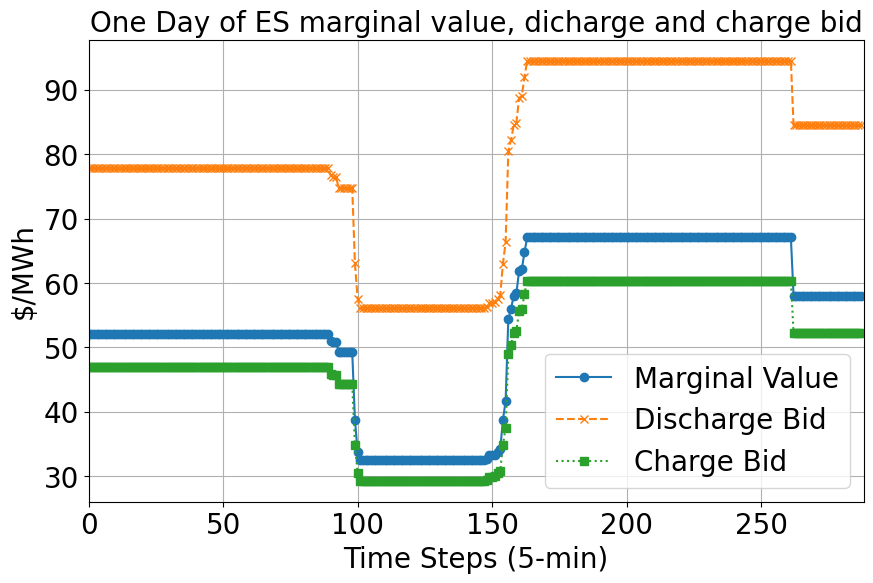

In [12]:
Tend = 288
# Plot the n*1 ndarray
line1 = vAvg[0,0:Tend] / 0.9 + 20
line2 = vAvg[0,0:Tend] * 0.9
plt.figure(figsize=(10, 6))
plt.plot(vAvg[0,0:Tend], marker='o', linestyle='-', label='Marginal Value')
plt.plot(line1, marker='x', linestyle='--', label='Discharge Bid')
plt.plot(line2, marker='s', linestyle=':', label='Charge Bid')
plt.xlabel('Time Steps (5-min)', fontsize = 20)
plt.ylabel('$/MWh', fontsize = 20)
plt.title('One Day of ES marginal value, dicharge and charge bid', fontsize = 20)
plt.legend()
plt.xlim([0,288])

plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)


plt.grid(True)
plt.show()